### Cab-Driver Agent

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Data Science Projects/RL Cab Booking Agent')

In [ ]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [ ]:
# Additional Libraries
import time

#### Defining Time Matrix

In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("/content/drive/MyDrive/Data Science Projects/RL Cab Booking Agent/TM.npy")

#### Tracking the state-action pairs for checking convergence


In [ ]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_decay = -0.0005 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0, 1, 4] and action (1, 2) at index 6 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0, 1, 4])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        # Hidden Layers     
        model.add(Dense(32, input_dim = self.state_size, activation = 'relu', kernel_initializer = 'he_uniform'))
        model.add(Dense(32, activation = 'relu', kernel_initializer = 'he_uniform'))
        # The output layer having size equal to the Action space size
        model.add(Dense(self.action_size, activation = 'relu', kernel_initializer ='he_uniform'))
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):        
        # Get action from model using epsilon-greedy policy
        # Decay in ε after each episode    

        if np.random.rand() > self.epsilon:
            # Exploitation - We will try to select the action with the maximum Returns i.e, highest q(s, a)
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # Truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

        else:
            # Exploration: we will choose a random action from the ride requests
            return random.choice(possible_actions_index)
        

    def append_sample(self, state, action_index, reward, next_state, terminal):
         # save sample <s, a, r, s, terminal> to the replay memory
        self.memory.append((state, action_index, reward, next_state, terminal))
        
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # We will train our model here using random batches from the memory
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # Initializing the two matrices that will be fed to our neural network- update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, terminal = [], [], []

            # Populate update_input and update_output and the lists rewards, actions, terminal
            for i in range(self.batch_size):
                state, action, reward, next_state, is_terminal = mini_batch[i]
                    
                actions.append(action)
                rewards.append(reward)
                terminal.append(is_terminal)
                # RL Environment built on top of Architecture 1
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                

            # Predict the q-values for state s
            qval = self.model.predict(update_input)
            # Predict the q-values for next state s'(target q-value)
            target_qval = self.model.predict(update_output)


            # Update the target values
            for i in range(self.batch_size):
                if terminal[i]:
                    qval[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    qval[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # Fit the model
            self.model.fit(update_input, qval, batch_size=self.batch_size, epochs = 1, verbose=0)
            
    def save_tracked_state(self):
        # We will use the model to predict the q_value of the state being tracked
        q_value = self.model.predict(self.track_state)
        
        # Appending the q_value to the states_tracked attribute of the agent
        self.states_tracked.append(q_value[0][6])
        
    def save(self, name):
        self.model.save('/content/drive/MyDrive/Data Science Projects/RL Cab Booking Agent/Saved Models/'+name+".h5")

### DQN block

In [ ]:
# Setting up our parameters

m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m + t + d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size = action_size , state_size = state_size)

# To store rewards in each episode
rewards_per_episode, episodes = [], []


In [ ]:
# Observing the model summary of our Agent
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


### Tracking Convergence

In [ ]:
# Episode Time to determine when terminal state will be reached
episode_time = 24 * 30 
# Total number of episodes
n_episodes = 2000

tic = time.time()
score_tracked = []
print_checkpoint = 5
save_track_checkpoint = 10
save_model_checkpoint = 100

for episode in range(n_episodes):

    terminal = False
    score = 0
    track_reward = False
    print("*"*80)
    print("Episode ", (episode + 1) )
   

    # Invoke the Environment
    env = CabDriver()

    # Resetting at the start of each episode
    action_space, state_space, state = env.reset()

    total_time = 0  # Initializing the total time driven by cab as 0 at the beginning of our Episode

    while not terminal:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        next_state = env.next_state_func(state, action_space[action], Time_matrix)
        time_spent_t1, time_spent_t2 = env.cal_time(state, action_space[action], Time_matrix)
        reward = env.reward_func(state, action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += (time_spent_t1 + time_spent_t2)
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            terminal = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values
            score += reward
            state = next_state

    # We will now save the rewards per episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # Apply epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # Print results every X episodes:
    if (episode + 1) % print_checkpoint == 0:
        print("Episode: ", (episode + 1), ", Reward: ", score," Current Epsilon: ", agent.epsilon, "Time: ", total_time)
        
    # Save the Q_value of the state, action pair we are tracking
    if (episode + 1) % save_track_checkpoint == 0:
        agent.save_tracked_state()

    # Total rewards per episode
    score_tracked.append(score)

    if (episode + 1) % save_model_checkpoint == 0:
        print("Saving Model {}".format(episode + 1))
        agent.save("RL_Model_"+str(episode + 1))
    
toc = time.time()
print("Total Time in Seconds -",toc - tic)


********************************************************************************
Episode  1
********************************************************************************
Episode  2
********************************************************************************
Episode  3
********************************************************************************
Episode  4
********************************************************************************
Episode  5
Episode:  5 , Reward:  -49.0  Current Epsilon:  0.9979920186473464 Time:  729.0
********************************************************************************
Episode  6
********************************************************************************
Episode  7
********************************************************************************
Episode  8
********************************************************************************
Episode  9
********************************************************************************
Episode  10

# Convergence of the Total Rewards per Episode

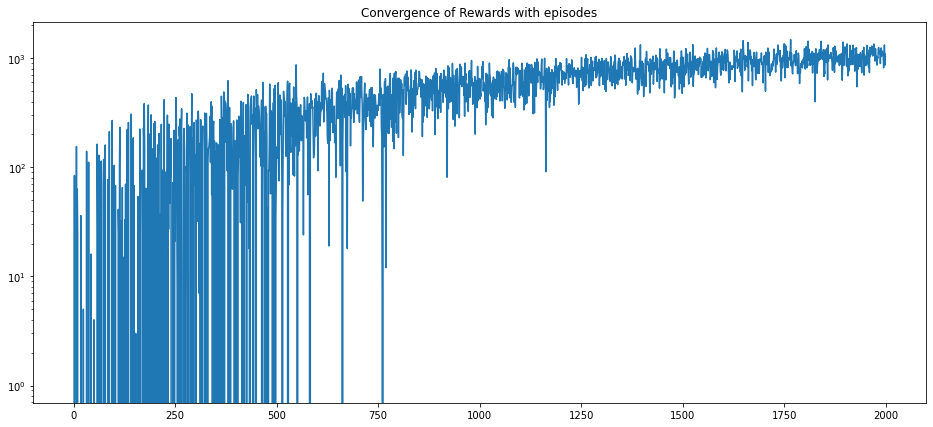

In [ ]:
# Plotting a line plot with log scaling

plt.figure(0, figsize=(16,7))
plt.title('Convergence of Rewards with episodes')
x_axis = np.asarray(range(0, len(rewards_per_episode)))
plt.semilogy(x_axis,np.asarray(rewards_per_episode))
plt.show()


##Visualizing the convergence for a tracked state and action pair of state [0, 1, 4] and action (1, 2)

In [ ]:
# Plotting a line plot with log scaling
plt.figure(0, figsize=(16,7))
plt.title('Reward convergence for state [0,1,4]  action (1,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()